In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import logging
from sklearn.utils import shuffle

import tensorflow as tf

tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras.callbacks import ModelCheckpoint

from src.segmentation.image import Preprocessor
from src.segmentation.model import (
    CosineAnnealingLearningRateSchedule,
    SegmentationModel,
)
from src.utils import (Const, Estimator)

# 1. Loading data

In [2]:
def load_samples(folder_path):
    samples = []

    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        file_paths = os.listdir(folder_path)
        for i in tqdm.trange(len(file_paths)):
            path = os.path.join(folder_path, file_paths[i])
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE) / 255.
            samples.append(sample.reshape(Const.IMG_SIZE, Const.IMG_SIZE, 1))

    return np.array(samples)

In [3]:
imgs_ct = load_samples(Const.CT_IMAGES_PATH)
imgs_lungs = load_samples(Const.LUNGS_IMAGES_PATH)
imgs_covid = load_samples(Const.COVID_IMAGES_PATH)

100%|██████████| 1614/1614 [00:00<00:00, 1970.14it/s]


In [4]:
print(f'{imgs_ct.shape=}')
print(f'{imgs_lungs.shape=}')
print(f'{imgs_covid.shape=}')

print(f'{imgs_ct.min()=} {imgs_ct.max()=}')
print(f'{imgs_lungs.min()=} {imgs_lungs.max()=}')
print(f'{imgs_covid.min()=} {imgs_covid.max()=}')

imgs_ct.shape=(1614, 256, 256, 1)
imgs_lungs.shape=(1614, 256, 256, 1)
imgs_covid.shape=(1614, 256, 256, 1)
imgs_ct.min()=0.0 imgs_ct.max()=1.0
imgs_lungs.min()=0.0 imgs_lungs.max()=1.0
imgs_covid.min()=0.0 imgs_covid.max()=1.0


## Shuffle the data

In [5]:
imgs_ct, imgs_lungs, imgs_covid = shuffle(imgs_ct, imgs_lungs, imgs_covid)

# 2. Splitting data into training and validation sets

In [6]:
TRAIN_SIZE = int(0.8 * imgs_ct.shape[0])
TEST_SIZE = int(0.1 * imgs_ct.shape[0])

train_x, train_lungs, train_covid = (
    imgs_ct[:TRAIN_SIZE],
    imgs_lungs[:TRAIN_SIZE],
    imgs_covid[:TRAIN_SIZE],
)
valid_x, valid_lungs, valid_covid = (
    imgs_ct[TRAIN_SIZE:],
    imgs_lungs[TRAIN_SIZE:],
    imgs_covid[TRAIN_SIZE:],
)
test_x, test_lungs, test_covid = (
    imgs_ct[:TEST_SIZE],
    imgs_lungs[:TEST_SIZE],
    imgs_covid[:TEST_SIZE],
)

print(f'{train_x.shape=}, {train_lungs.shape=}, {train_covid.shape=}')
print(f'{valid_x.shape=}, {valid_lungs.shape=}, {valid_covid.shape=}')
print(f'{test_x.shape=}, {test_lungs.shape=}, {test_covid.shape=}')

del imgs_ct, imgs_lungs, imgs_covid
del TRAIN_SIZE, TEST_SIZE

train_x.shape=(1291, 256, 256, 1), train_lungs.shape=(1291, 256, 256, 1), train_covid.shape=(1291, 256, 256, 1)
valid_x.shape=(323, 256, 256, 1), valid_lungs.shape=(323, 256, 256, 1), valid_covid.shape=(323, 256, 256, 1)
test_x.shape=(161, 256, 256, 1), test_lungs.shape=(161, 256, 256, 1), test_covid.shape=(161, 256, 256, 1)


# 3. Train Model

We will use dice coefficient as a metric for infection segmentation.
Dice coefficient is

$$\frac{2 TP}{2 TP+FN+FP}$$

where $TP$, $FN$ and $FP$ correspond to true positive, false negative and false positive.

In [7]:
EPOCHS = 50
BATCH_SIZE = 16
FROM_SCRATCH = True

In [8]:
lungs_segmentation = SegmentationModel(train_x.shape[1:])
covid_segmentation = SegmentationModel(train_x.shape[1:])

lungs_segmentation.compile()
covid_segmentation.compile()

if not FROM_SCRATCH:
    if os.path.exists(Const.LUNGS_MODEL_WEIGHTS_PATH) and os.path.exists(Const.COVID_MODEL_WEIGHTS_PATH):
        try:
            lungs_segmentation.load_weights(Const.LUNGS_MODEL_WEIGHTS_PATH)
            covid_segmentation.load_weights(Const.COVID_MODEL_WEIGHTS_PATH)
        except Exception as e:
            e.with_traceback()

In [9]:
def load_history(csv_path):
    columns = ['loss', 'val_loss', 'dice', 'val_dice']
    df = pd.read_csv(csv_path, index_col=False, names=columns, header=0)

    res = dict()
    res['epochs'] = len(df.loss)
    res['loss'] = df.loss.to_list()
    res['val_loss'] = df.val_loss.to_list()
    res['dice'] = df.dice.to_list()
    res['val_dice'] = df.val_dice.to_list()

    return res


def save_history(history, csv_path):
    columns = ['loss', 'val_loss', 'dice', 'val_dice']

    if os.path.exists(csv_path) and os.path.isfile(csv_path):
        history_csv = pd.read_csv(csv_path, index_col=False, names=columns, header=0)
    else:
        history_csv = pd.DataFrame([], columns=columns)

    values = []

    for epoch in history.epoch:
        values.append([
            history.history['loss'][epoch],
            history.history['val_loss'][epoch],
            history.history['dice'][epoch],
            history.history['val_dice'][epoch],
        ]
        )

    df = pd.DataFrame(values, columns=columns)

    history_csv = history_csv.append(df, ignore_index=True)
    history_csv.to_csv(csv_path, index=False)

## Lungs

In [10]:
lungs_history = lungs_segmentation.fit(
        X=train_x,
        Y=train_lungs,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(valid_x, valid_lungs),
        callbacks=[
            ModelCheckpoint(
                    filepath=Const.LUNGS_MODEL_WEIGHTS_PATH,
                    monitor='val_dice',
                    mode='max',
                    save_best_only=True,
                    save_weights_only=True,
            ),
            CosineAnnealingLearningRateSchedule(
                    n_epochs=EPOCHS,
                    n_cycles=EPOCHS / 25,
                    lrate_max=5e-5,
            ),
        ],
        verbose=2,
)
save_history(lungs_history, Const.LUNGS_HISTORY_PATH)

Epoch 1/50
81/81 - 30s - loss: 0.3248 - dice: 0.5877 - val_loss: 0.6380 - val_dice: 0.1473
Epoch 2/50
81/81 - 27s - loss: 0.1010 - dice: 0.8755 - val_loss: 0.8890 - val_dice: 0.0138
Epoch 3/50
81/81 - 27s - loss: 0.0647 - dice: 0.9220 - val_loss: 1.0268 - val_dice: 0.0044
Epoch 4/50
81/81 - 27s - loss: 0.0479 - dice: 0.9419 - val_loss: 1.0858 - val_dice: 0.0132
Epoch 5/50
81/81 - 27s - loss: 0.0393 - dice: 0.9525 - val_loss: 0.9750 - val_dice: 0.1412
Epoch 6/50
81/81 - 28s - loss: 0.0349 - dice: 0.9577 - val_loss: 0.7272 - val_dice: 0.3875
Epoch 7/50
81/81 - 28s - loss: 0.0321 - dice: 0.9615 - val_loss: 0.2547 - val_dice: 0.7955
Epoch 8/50
81/81 - 28s - loss: 0.0291 - dice: 0.9649 - val_loss: 0.1346 - val_dice: 0.8830
Epoch 9/50
81/81 - 28s - loss: 0.0277 - dice: 0.9665 - val_loss: 0.0539 - val_dice: 0.9480
Epoch 10/50
81/81 - 28s - loss: 0.0253 - dice: 0.9695 - val_loss: 0.0363 - val_dice: 0.9632
Epoch 11/50
81/81 - 27s - loss: 0.0248 - dice: 0.9703 - val_loss: 0.0406 - val_dice: 0.95

## Covid

In [11]:
covid_history = covid_segmentation.fit(
        X=train_x,
        Y=train_covid,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(valid_x, valid_covid),
        callbacks=[
            ModelCheckpoint(
                    filepath=Const.COVID_MODEL_WEIGHTS_PATH,
                    monitor='val_dice',
                    mode='max',
                    save_best_only=True,
                    save_weights_only=True,
            ),
            CosineAnnealingLearningRateSchedule(
                    n_epochs=EPOCHS,
                    n_cycles=EPOCHS / 25,
                    lrate_max=5e-5,
            ),
        ],
        verbose=2,
)
save_history(covid_history, Const.COVID_HISTORY_PATH)


Epoch 1/50
81/81 - 28s - loss: 0.5085 - dice: 0.0936 - val_loss: 0.5479 - val_dice: 0.0084
Epoch 2/50
81/81 - 27s - loss: 0.3346 - dice: 0.3942 - val_loss: 0.5567 - val_dice: 0.0041
Epoch 3/50
81/81 - 27s - loss: 0.2779 - dice: 0.5059 - val_loss: 0.5721 - val_dice: 0.0034
Epoch 4/50
81/81 - 27s - loss: 0.2468 - dice: 0.5645 - val_loss: 0.5847 - val_dice: 0.0037
Epoch 5/50
81/81 - 28s - loss: 0.2283 - dice: 0.5973 - val_loss: 0.5535 - val_dice: 0.0603
Epoch 6/50
81/81 - 28s - loss: 0.2149 - dice: 0.6214 - val_loss: 0.4290 - val_dice: 0.2614
Epoch 7/50
81/81 - 28s - loss: 0.2027 - dice: 0.6445 - val_loss: 0.3264 - val_dice: 0.4317
Epoch 8/50
81/81 - 28s - loss: 0.1945 - dice: 0.6581 - val_loss: 0.2171 - val_dice: 0.6131
Epoch 9/50
81/81 - 28s - loss: 0.1873 - dice: 0.6712 - val_loss: 0.2167 - val_dice: 0.6198
Epoch 10/50
81/81 - 28s - loss: 0.1785 - dice: 0.6867 - val_loss: 0.1934 - val_dice: 0.6567
Epoch 11/50
81/81 - 27s - loss: 0.1741 - dice: 0.6951 - val_loss: 0.2055 - val_dice: 0.63

In [12]:
lungs_history = load_history(Const.LUNGS_HISTORY_PATH)
covid_history = load_history(Const.COVID_HISTORY_PATH)

In [13]:
def plot_history(history, title):
    plt.style.use('ggplot')

    _, axes = plt.subplots(ncols=2, figsize=(16, 9))
    plt.title(title)

    axes[0].plot(history['dice'], color='black', label='Train')
    axes[0].plot(history['val_dice'], color='limegreen', label='Validation')
    axes[0].set_ylabel('Dice coefficient')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='best')

    axes[1].plot(history['loss'], color='black', label='Train')
    axes[1].plot(history['val_loss'], color='limegreen', label='Validation')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='best')

    plt.show()

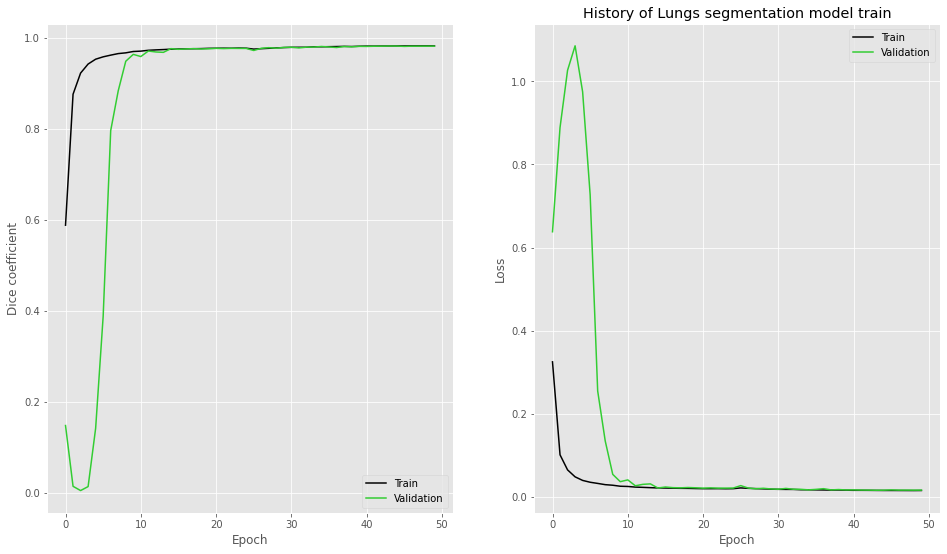

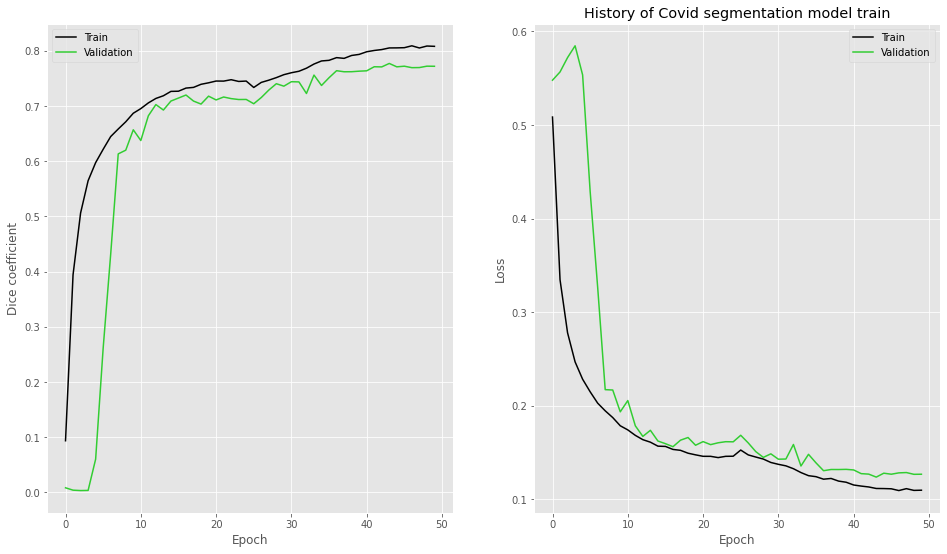

In [14]:
plot_history(lungs_history, 'History of Lungs segmentation model train')
plot_history(covid_history, 'History of Covid segmentation model train')

del BATCH_SIZE, EPOCHS, FROM_SCRATCH
del lungs_history, covid_history

# 7. Testing

[57, 145, 33, 87, 72]


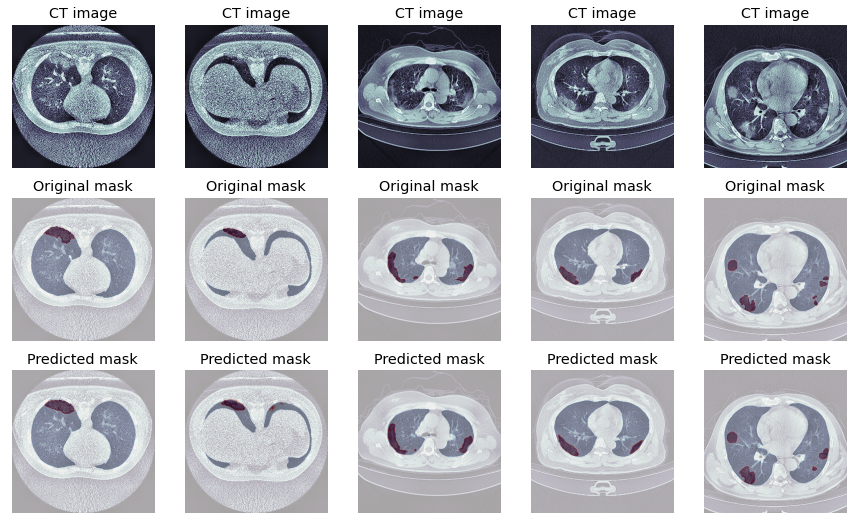

In [15]:
lungs_segmentation.load_weights(Const.LUNGS_MODEL_WEIGHTS_PATH)
covid_segmentation.load_weights(Const.COVID_MODEL_WEIGHTS_PATH)

lungs_prediction = lungs_segmentation.predict(test_x)
covid_prediction = covid_segmentation.predict(test_x)

indices = random.choices(range(len(test_x)), k=5)
_, axes = plt.subplots(3, 5, figsize=(15, 9))

print(indices)

for ii, idx in enumerate(indices):
    axes[0, ii].imshow(test_x[idx], cmap='bone')
    axes[0, ii].set_title('CT image')
    axes[0, ii].set_xticks([])
    axes[0, ii].set_yticks([])
    plt.grid()

    axes[1, ii].imshow(test_x[idx], cmap='bone')
    axes[1, ii].imshow(test_lungs[idx], alpha=0.4, cmap='Blues')
    axes[1, ii].imshow(test_covid[idx], alpha=0.4, cmap='Reds')
    axes[1, ii].set_title('Original mask')
    axes[1, ii].set_xticks([])
    axes[1, ii].set_yticks([])
    plt.grid()

    axes[2, ii].imshow(test_x[idx], cmap='bone')
    axes[2, ii].imshow(lungs_prediction[idx], alpha=0.4, cmap='Blues')
    axes[2, ii].imshow(covid_prediction[idx], alpha=0.4, cmap='Reds')
    axes[2, ii].set_title('Predicted mask')
    axes[2, ii].set_xticks([])
    axes[2, ii].set_yticks([])
    plt.grid()

del lungs_segmentation, covid_segmentation
del indices, axes, ii, idx
del train_x, train_lungs, train_covid, valid_x, valid_lungs, valid_covid, test_lungs, test_covid

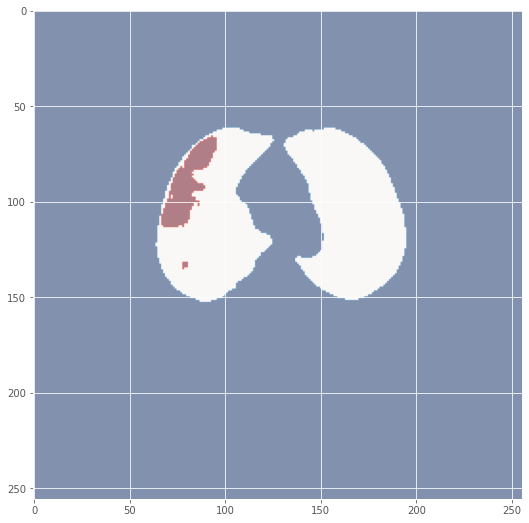

8.21%


In [16]:
ind = random.randint(0, len(test_x) - 1)

lungs_image = Preprocessor.binarize(lungs_prediction[ind].copy())
covid_image = Preprocessor.binarize(covid_prediction[ind].copy())

plt.figure(figsize=(9, 9))
plt.imshow(lungs_image, cmap='Blues_r')
plt.imshow(covid_image, alpha=0.5, cmap='Reds')
plt.show()

print(f'{Estimator.content(covid_prediction[ind], lungs_prediction[ind]):.2%}')

del ind, lungs_image, covid_image